In [71]:
import sys
import os
import glob
import math
import argparse
import numpy as np
import cv2
import json

import matplotlib.pyplot as plt
import os
import random
%matplotlib inline

In [ ]:
rs19_label2bgr = {"buffer-stop": (70, 70, 70),
                  "crossing": (128, 64, 128),
                  "guard-rail": (0, 255, 0),
                  "train-car":  (100, 80, 0),
                  "platform": (232, 35, 244),
                  "rail": (255, 255, 0),
                  "switch-indicator": (127, 255, 0),
                  "switch-left": (255, 255, 0),
                  "switch-right": (127, 127, 0),
                  "switch-unknown": (191, 191, 0),
                  "switch-static": (0, 255, 127),
                  "track-sign-front": (0, 220, 220),
                  "track-signal-front": (30, 170, 250),
                  "track-signal-back": (0, 85, 125),
                  # rail occluders
                  "person-group": (60, 20, 220),
                  "car": (142, 0, 0),
                  "fence": (153, 153, 190),
                  "person": (60, 20, 220),
                  "pole": (153, 153, 153),
                  "rail-occluder": (255, 255, 255),
                  "truck": (70, 0, 0)
                  }

In [114]:
def files_in_subdirs(start_dir, pattern=["*.png", "*.jpg", "*.jpeg"]):
    files = []
    for p in pattern:
        for dir, _, _ in os.walk(start_dir):
            files.extend(glob.glob(os.path.join(dir, p)))
    return files


def config_to_rgb(inp_path_config_json, default_col=[255, 255, 255]):
    lut = []
    inp_json = json.load(open(inp_path_config_json, 'r'))
    for c in range(3):  # for each color channel
        lut_c = [l["color"][c] for l in inp_json["labels"]] + \
            [default_col[c]]*(256-len(inp_json["labels"]))
        lut.append(np.asarray(lut_c, dtype=np.uint8))
    return lut


def corss_hatch_rail(im_vis, coords, color_left=(255, 255, 0), color_right=(127, 127, 0)):
    ml = min(len(coords[0]), len(coords[1]))
    for i in range(ml):
        midpnt = ((coords[0][i][0]+coords[1][i][0])//2,
                  (coords[0][i][1]+coords[1][i][1])//2)
        cv2.line(im_vis, tuple(coords[0][i]), midpnt, color_left)
        cv2.line(im_vis, midpnt, tuple(coords[1][i]), color_right)


def json_to_img(inp_path_json, line_thickness=2):
    inp_json = json.load(open(inp_path_json, 'r'))
    im_json = np.zeros(
        (inp_json["imgHeight"], inp_json["imgWidth"], 3), dtype=np.uint8)
    for obj in inp_json["objects"]:
        col = rs19_label2bgr.get(obj["label"], [255, 255, 255])
        if "boundingbox" in obj:
            cv2.rectangle(im_json, tuple(obj["boundingbox"][0:2]), tuple(
                obj["boundingbox"][2:4]), col, line_thickness)
        elif "polygon" in obj:
            pnts_draw = np.around(np.array(obj["polygon"])).astype(np.int32)
            cv2.polylines(im_json, [pnts_draw], True, col, line_thickness)
        elif "polyline-pair" in obj:
            # left rail of a rail pair has index 0, right rail of a rail pair has index 1
            rails_draw = [np.around(
                np.array(obj["polyline-pair"][i])).astype(np.int32) for i in range(2)]
            corss_hatch_rail(
                im_json, obj["polyline-pair"],  rs19_label2bgr['switch-left'], rs19_label2bgr['switch-right'])
            cv2.polylines(im_json, rails_draw, False, col)
        elif "polyline" in obj:
            rail_draw = np.around(np.array(obj["polyline"])).astype(np.int32)
            cv2.polylines(im_json, [rail_draw], False, col, line_thickness)
    return im_json, inp_json["frame"]


def get_joined_img(inp_path_json, jpg_folder, uint8_folder, lut_bgr, blend_vals=[0.65, 0.25, 0.1]):
    # visualize geometric annotations
    im_json, frameid = json_to_img(inp_path_json, line_thickness=2)
    inp_path_jpg = os.path.join(jpg_folder, frameid+".jpg")
    inp_path_uint8 = os.path.join(uint8_folder, frameid+".png")
    im_jpg = cv2.imread(inp_path_jpg)  # add intensity image as background
    # get semantic label map
    im_id_map = cv2.imread(inp_path_uint8, cv2.IMREAD_GRAYSCALE)
    im_id_col = np.zeros((im_id_map.shape[0], im_id_map.shape[1], 3), np.uint8)
    for c in range(3):
        im_id_col[:, :, c] = lut_bgr[c][im_id_map]  # apply color coding
    # blend all three data sources
    return (im_jpg*blend_vals[0]+im_id_col*blend_vals[1]+im_json*blend_vals[2]).astype(np.uint8)


def vis_all_json(json_folder, jpg_folder, uint8_folder, inp_path_config_json):
    all_json = files_in_subdirs(json_folder, pattern=["*.json"])
    lut_bgr = config_to_rgb(inp_path_config_json, default_col=[255, 255, 255])[
        ::-1]  # we need to swap color channels as opencv uses BGR
    curr_idx, retKey = 1, ord('a')
    while retKey > ord(' '):
        im_vis = get_joined_img(
            all_json[curr_idx], jpg_folder, uint8_folder, lut_bgr)
        cv2.putText(im_vis, all_json[curr_idx], (0, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        cv2.imshow(
            "RailSem19 Annotation Visualization (use 'a' or 'd' to navigate, ESC to quit)", im_vis)
        retKey = cv2.waitKey(-1)  # use 'a' and 'd' to scroll through frames
        curr_idx = curr_idx - 1 if retKey == ord('a') else curr_idx + 1
        curr_idx = (curr_idx + len(all_json)) % len(all_json)  # wrap around
    return 0

In [115]:
base_path = 'datasets/rs19'
jsons_path = os.path.join(base_path, 'jsons/rs19_val')
jpgs_path = os.path.join(base_path, 'jpgs/rs19_val')
uint8_path = os.path.join(base_path, 'uint8/rs19_val')
config_path = os.path.join(base_path, 'rs19-config.json')
vis_all_json(jsons_path, jpgs_path, jpgs_path, config_path)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
all_json = files_in_subdirs(jsons_path, pattern=["*.json"])

In [ ]:
lut_bgr = config_to_rgb(config_path, default_col=[255, 255, 255])[
    ::-1]  # we need to swap color channels as opencv uses BGR

In [117]:
im_vis = get_joined_img(all_json[1], jsons_path, uint8_path, lut_bgr)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
im_vis.shape

In [ ]:
tmp = cv2.putText(im_vis, all_json[1], (0, 25),
                  cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

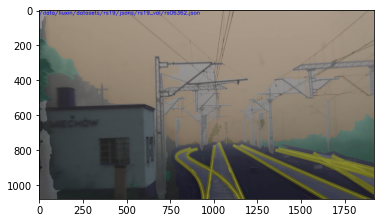

In [112]:
plt.imshow(im_vis)

In [ ]:
im_json, frameid = json_to_img(all_json[0], line_thickness=2)

In [ ]:
frameid

In [ ]:
inp_json = json.load(open(all_json[1], 'r'))
inp_json

In [ ]:
json.load(open(config_path, 'r'))

In [72]:
trainval_percent = 0.8  # 训练集和验证集所占比例，剩下的0.2是测试集比例
train_percent = 0.8  # 训练集所占比例


base_path = 'datasets/rs19'
jsons_path = os.path.join(base_path, 'jsons/rs19_val')
jpgs_path = os.path.join(base_path, 'jpgs/rs19_val')
uint8_path = os.path.join(base_path, 'uint8/rs19_val')
config_path = os.path.join(base_path, 'rs19-config.json')


txtsavepath = base_path
totaljsons = files_in_subdirs(jsons_path, pattern=["*.json"])

In [ ]:
num = len(totaljsons)
list = range(num)
tv = int(num * trainval_percent)
tr = int(tv * train_percent)
trainval = random.sample(list, tv)
train = random.sample(trainval, tr)

In [159]:
ftrainval = open(os.path.join(txtsavepath, 'trainval.txt'), 'w')
ftest = open(os.path.join(txtsavepath, 'test.txt'), 'w')
ftrain = open(os.path.join(txtsavepath, 'train.txt'), 'w')
fval = open(os.path.join(txtsavepath, 'val.txt'), 'w')

In [ ]:
totaljsons[:5]

In [ ]:
totaljsons[0].split('/', 5)[-1].replace('jsons',
                                        'jpgs').replace('.json', '.jpg')

In [160]:
for i in list:
    name = './' + totaljsons[i].split('/', 5)[-1].replace(
        'jsons', 'images').replace('.json', '.jpg') + '\n'
    if i in trainval:
        ftrainval.write(name)
        if i in train:
            ftrain.write(name)
        else:
            fval.write(name)
    else:
        ftest.write(name)
ftrainval.close()
ftrain.close()
fval.close()
ftest.close()

In [ ]:
def json_to_img(inp_path_json, line_thickness=2):
    inp_json = json.load(open(inp_path_json, 'r'))
    im_json = np.zeros(
        (inp_json["imgHeight"], inp_json["imgWidth"], 3), dtype=np.uint8)
    for obj in inp_json["objects"]:
        col = rs19_label2bgr.get(obj["label"], [255, 255, 255])
        if "boundingbox" in obj:
            cv2.rectangle(im_json, tuple(obj["boundingbox"][0:2]), tuple(
                obj["boundingbox"][2:4]), col, line_thickness)
        elif "polygon" in obj:
            pnts_draw = np.around(np.array(obj["polygon"])).astype(np.int32)
            cv2.polylines(im_json, [pnts_draw], True, col, line_thickness)
        elif "polyline-pair" in obj:
            # left rail of a rail pair has index 0, right rail of a rail pair has index 1
            rails_draw = [np.around(
                np.array(obj["polyline-pair"][i])).astype(np.int32) for i in range(2)]
            corss_hatch_rail(
                im_json, obj["polyline-pair"],  rs19_label2bgr['switch-left'], rs19_label2bgr['switch-right'])
            cv2.polylines(im_json, rails_draw, False, col)
        elif "polyline" in obj:
            rail_draw = np.around(np.array(obj["polyline"])).astype(np.int32)
            cv2.polylines(im_json, [rail_draw], False, col, line_thickness)
    return im_json, inp_json["frame"]

In [122]:
tmp = json.load(open(totaljsons[1], 'r'))
print(['boundingbox'])

[787, 622, 812, 680]


In [123]:
tmp.keys()

dict_keys(['frame', 'imgHeight', 'imgWidth', 'objects'])

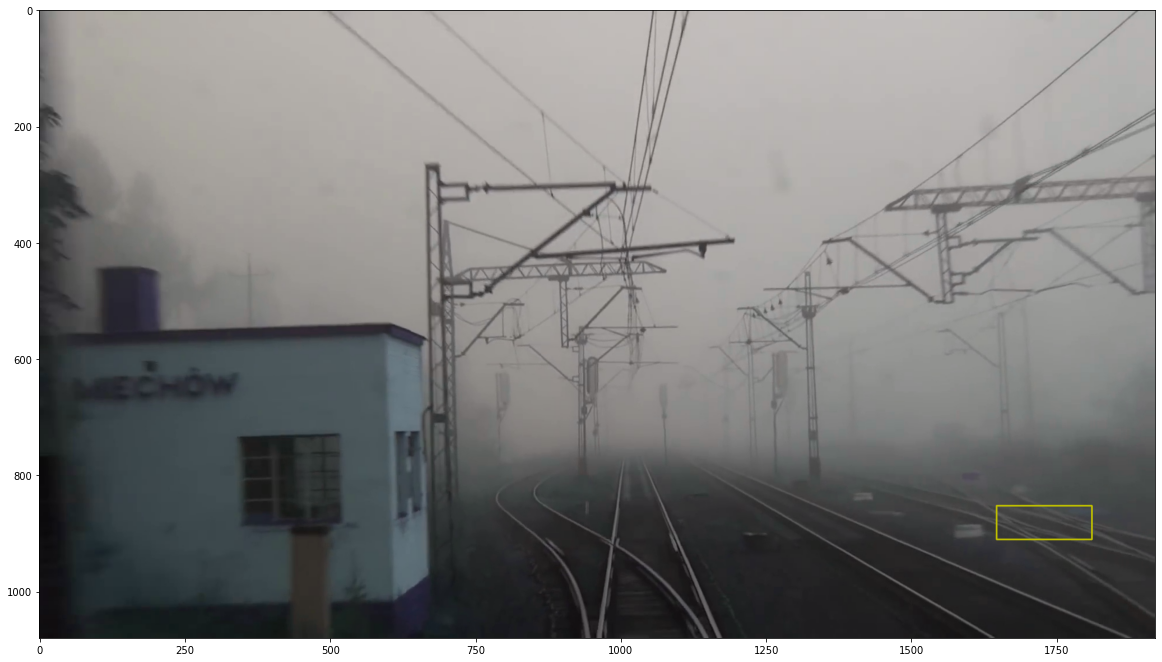

In [136]:
im_json = cv2.imread(
    'datasets/rs19/jpgs/rs19_val/'+tmp['frame']+'.jpg')
obj = tmp['objects'][3]
col = rs19_label2bgr.get(obj["label"], [255, 255, 255])
line_thickness = 2
out = cv2.rectangle(im_json, tuple(obj["boundingbox"][0:2]), tuple(
    obj["boundingbox"][2:4]), col, line_thickness)
plt.figure(figsize=(20, 20))
plt.imshow(out)

In [94]:
if 'boundingbox' in tmp['objects'][0].keys():
    print(tmp['objects'][0]['label'])

track-signal-back


In [98]:
class_list = []
for json_ in totaljsons[]:
    anjson = json.load(open(json_, 'r'))
    objs = anjson['objects']
    for obj in objs:
        if 'boundingbox' in obj.keys():
            class_list.append(obj['label'])

In [104]:
class_list = ['buffer-stop',
              'crossing',
              'switch-indicator',
              'switch-left',
              'switch-right',
              'switch-static',
              'switch-unknown',
              'track-sign-front',
              'track-signal-back',
              'track-signal-front']

In [109]:
class_dict = dict(zip(class_list, range(len(class_list))))
class_dict

{'buffer-stop': 0,
 'crossing': 1,
 'switch-indicator': 2,
 'switch-left': 3,
 'switch-right': 4,
 'switch-static': 5,
 'switch-unknown': 6,
 'track-sign-front': 7,
 'track-signal-back': 8,
 'track-signal-front': 9}